## Imports and Params

In [14]:
from newsapi import NewsApiClient
from nytimesarticle import articleAPI
import pandas_datareader.data as web
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dateutil
import time
import quandl
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pandas.plotting import autocorrelation_plot
from pandas.tools.plotting import lag_plot
from statsmodels.tsa.ar_model import AR
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression


In [20]:
# Params
# extra API keys, comment out as necessary
#api = articleAPI("b23351c6f9314694bfe4f4929a2b72c5") 
#api = articleAPI("787bd4db8e704bbf9cebe8b7941827e0") 
#api = articleAPI("f8b402f42ed14b249fd5accc95a050dd") 
#api = articleAPI("c91a676aeaef40fd844409c8b0bef485")
#api = articleAPI("c43133d654134109868299ff505e7c55")
#api = articleAPI("eb427ebc2336423ead4d350cfa4e900b")
#api = articleAPI("b538de93f1a9459da22b150d7b53cb6f")
api = articleAPI("88f587ed149d4478b4490168d61ed9dc")

quandl.ApiConfig.api_key = "2S7d7eeL5VZrLup9pKg5"
end_date = (datetime.datetime.now() - datetime.timedelta(days=3)).isoformat()
start_date = (datetime.datetime.now() - datetime.timedelta(days=2*365)).isoformat()
left_sources = 'The New York Times'
right_sources = 'Fox News'
center_sources = 'Reuters AP The Wall Street Journal'
all_sources = left_sources + ' ' + right_sources + ' ' + center_sources
replace_list = ['Corp', 'Inc', 'Inc.', '.com', 'plc', ',', 'Co.']
# domain

In [21]:
def main():
    # retrieve s&p 500 companies 
    df = pd.read_csv('constituents_csv.csv')
    companies = df['Name']
    company_symb = {}

    # Iterate through companies
    # for company in companies:
    for i in range(30,31):

        company = companies.loc[i]

        # get company ticker
        company_symb[company] = df[df['Name'] == company]['Symbol']
        ticker = company_symb[company].values[0]
        
        # get rid of suffixes from company name
        for word in replace_list:
            company = company.replace(word, '')

        # initialize the dataframe
        lag = get_lag_period(ticker, start_date, end_date)
        df_current = initialize_dataframe(ticker, start_date, end_date, lag=lag)
        
        # Add sentiment columns in dataframe
        df_current['Pos_t-1'] = 0
        df_current['Neu_t-1'] = 0
        df_current['Neg_t-1'] = 0

        # Query news articles
        trading_dates = df_current.index
        dict_current = query_news_articles(company, start_date, end_date, trading_dates, sources=all_sources)

        # iterate through dates
        for date in dict_current.keys():
            # when you enter seniment into the dataframe, use the before date not after
            average_sentiment_dict = calculate_sentiment(dict_current[date])

            # Plug this into df current
            df_current.at[date,'Pos_t-1'] = average_sentiment_dict['pos']
            df_current.at[date,'Neu_t-1'] = average_sentiment_dict['neu']
            df_current.at[date,'Neg_t-1'] = average_sentiment_dict['neg']
            
        print(i, ticker, 'success')
        #df_current.to_csv('./data/'+ticker+'.csv')
        #df_current = df_current.reset_index()
        return df_current

            # print(i, ticker, 'failed')
            # pass

In [22]:
a = main()
a.head()

amazon .
headline:(amazon .) or body:(amazon .) and source:(the new york times fox news reuters ap the wall street journal)
page 0
amazon .
headline:(amazon .) or body:(amazon .) and source:(the new york times fox news reuters ap the wall street journal)
2018-04-13T17:09:19+0000
2018-05-03T18:54:19+0000
2017-09-18T12:59:01+0000
2018-05-03T00:46:35+0000
2018-04-26T21:52:43+0000
2018-05-03T00:42:54+0000
2017-08-24T21:30:08+0000
2018-03-30T15:45:21+0000
2018-05-01T23:31:12+0000
2018-04-27T20:46:43+0000
page 1
amazon .
headline:(amazon .) or body:(amazon .) and source:(the new york times fox news reuters ap the wall street journal)
2018-05-03T19:55:32+0000
2018-05-03T06:37:35+0000
2018-05-01T14:34:39+0000
2018-05-01T07:10:43+0000
2018-04-30T23:16:32+0000
2018-05-02T08:22:32+0000
2018-05-02T20:25:47+0000
2018-05-01T03:40:38+0000
2018-04-04T09:11:09+0000
2018-04-30T23:19:32+0000
page 2
amazon .
headline:(amazon .) or body:(amazon .) and source:(the new york times fox news reuters ap the wall

2017-06-19T18:15:23+0000
2017-06-16T14:33:38+0000
2017-04-22T18:30:19+0000
2017-06-16T22:06:46+0000
2017-05-09T14:00:17+0000
2017-03-20T13:30:33+0000
2017-05-30T20:38:24+0000
2017-05-01T18:37:35+0000
2017-04-05T03:11:54+0000
2017-04-20T09:29:58+0000
page 22
amazon .
headline:(amazon .) or body:(amazon .) and source:(the new york times fox news reuters ap the wall street journal)
2017-03-23T19:48:52+0000
2017-05-16T00:42:30+0000
2017-05-10T04:01:18+0000
2017-02-20T17:14:40+0000
2017-03-13T16:55:47+0000
2017-02-24T17:46:45+0000
2017-03-31T18:20:20+0000
2017-04-28T00:52:54+0000
2017-03-31T20:22:28+0000
2018-02-14T10:00:50+0000
page 23
amazon .
headline:(amazon .) or body:(amazon .) and source:(the new york times fox news reuters ap the wall street journal)
2017-03-02T21:48:40+0000
2016-12-14T10:00:15+0000
2017-04-06T02:33:16+0000
2016-11-27T23:02:30+0000
2016-11-18T09:56:19+0000
2017-03-01T20:03:55+0000
2016-11-27T23:02:26+0000
2018-01-19T19:20:40+0000
2017-12-26T09:30:23+0000
2017-03-17T

page 72
amazon .
headline:(amazon .) or body:(amazon .) and source:(the new york times fox news reuters ap the wall street journal)
page 73
amazon .
headline:(amazon .) or body:(amazon .) and source:(the new york times fox news reuters ap the wall street journal)
page 74
amazon .
headline:(amazon .) or body:(amazon .) and source:(the new york times fox news reuters ap the wall street journal)
page 75
amazon .
headline:(amazon .) or body:(amazon .) and source:(the new york times fox news reuters ap the wall street journal)
page 76
amazon .
headline:(amazon .) or body:(amazon .) and source:(the new york times fox news reuters ap the wall street journal)
page 77
amazon .
headline:(amazon .) or body:(amazon .) and source:(the new york times fox news reuters ap the wall street journal)
page 78
amazon .
headline:(amazon .) or body:(amazon .) and source:(the new york times fox news reuters ap the wall street journal)
page 79
amazon .
headline:(amazon .) or body:(amazon .) and source:(the new 

page 134
amazon .
headline:(amazon .) or body:(amazon .) and source:(the new york times fox news reuters ap the wall street journal)
page 135
amazon .
headline:(amazon .) or body:(amazon .) and source:(the new york times fox news reuters ap the wall street journal)
page 136
amazon .
headline:(amazon .) or body:(amazon .) and source:(the new york times fox news reuters ap the wall street journal)
page 137
amazon .
headline:(amazon .) or body:(amazon .) and source:(the new york times fox news reuters ap the wall street journal)
page 138
amazon .
headline:(amazon .) or body:(amazon .) and source:(the new york times fox news reuters ap the wall street journal)
page 139
amazon .
headline:(amazon .) or body:(amazon .) and source:(the new york times fox news reuters ap the wall street journal)
page 140
amazon .
headline:(amazon .) or body:(amazon .) and source:(the new york times fox news reuters ap the wall street journal)
page 141
amazon .
headline:(amazon .) or body:(amazon .) and source:(

page 196
amazon .
headline:(amazon .) or body:(amazon .) and source:(the new york times fox news reuters ap the wall street journal)
page 197
amazon .
headline:(amazon .) or body:(amazon .) and source:(the new york times fox news reuters ap the wall street journal)
page 198
amazon .
headline:(amazon .) or body:(amazon .) and source:(the new york times fox news reuters ap the wall street journal)
page 199
amazon .
headline:(amazon .) or body:(amazon .) and source:(the new york times fox news reuters ap the wall street journal)
30 AMZN success


,X_t,X_t-1,X_t-2,X_t-3,X_t-4,X_t-5,X_t-6,X_t-7,X_t-8,X_t-9,...,X_t-11,X_t-12,X_t-13,X_t-14,X_t-15,X_t-16,X_t-17,Pos_t-1,Neu_t-1,Neg_t-1
Date,,,,,,,,,,,,,,,,,,,,,
2016-06-01,719.44,722.79,712.24,712.24,714.91,708.35,704.20,696.75,702.80,698.52,...,695.27,710.66,709.92,717.93,713.23,703.07,679.75,NaN,NaN,NaN
2016-06-02,728.24,719.44,722.79,712.24,712.24,714.91,708.35,704.20,696.75,702.80,...,697.45,695.27,710.66,709.92,717.93,713.23,703.07,NaN,NaN,NaN
2016-06-03,725.54,728.24,719.44,722.79,712.24,712.24,714.91,708.35,704.20,696.75,...,698.52,697.45,695.27,710.66,709.92,717.93,713.23,NaN,NaN,NaN
2016-06-06,726.73,725.54,728.24,719.44,722.79,712.24,712.24,714.91,708.35,704.20,...,702.80,698.52,697.45,695.27,710.66,709.92,717.93,NaN,NaN,NaN
2016-06-07,723.74,726.73,725.54,728.24,719.44,722.79,712.24,712.24,714.91,708.35,...,696.75,702.80,698.52,697.45,695.27,710.66,709.92,NaN,NaN,NaN


In [24]:
a.loc[datetime.date(2017,6,7)]

X_t        1010.070
X_t-1      1003.000
X_t-2      1011.340
X_t-3      1006.730
X_t-4       995.950
X_t-5       994.620
X_t-6       996.700
X_t-7       995.780
X_t-8       995.780
X_t-9       993.380
X_t-10      980.350
X_t-11      971.540
X_t-12      970.670
X_t-13      959.840
X_t-14      958.490
X_t-15      944.760
X_t-16      966.070
X_t-17      957.970
Pos_t-1       0.130
Neu_t-1       0.687
Neg_t-1       0.183
Name: 2017-06-07 00:00:00, dtype: float64

### Methods Used for Data Collection

In [3]:
def calculate_sentiment(sentence_arr):
    """ Returns the average sentiment of the array
    Params:
        sentence_arr(Array): Array of setences that we have to calculate
        the sentiment of.
    Returns:
        sentiment (dictionary): Takes the average of all sentences
        format of score is {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
    """
    sia = SentimentIntensityAnalyzer()
    df = df = pd.DataFrame(columns=['neg','neu','pos','compound'])
    for sentence in sentence_arr:
        sentiment = sia.polarity_scores(sentence)
        df_sentiment = pd.DataFrame([sentiment], columns=sentiment.keys())
        df = df.append(df_sentiment)
    
    avg_sentiment = dict(df.mean())    
    return avg_sentiment 

In [4]:
def query_news_articles(company, start_date, end_date, trading_dates, sources):
    """ Queries news article for a certain time frame and split it by dates
        Note that
    Params:
        company (String): Name of company
        start_date (String): Start date in format of "2001-12-31"
        end_date (String): End date in format of "2001-12-31"
         trading_dates (Array of Strings): Array of dates when the market was open
                 dates in format of "2001-12-31"
        sources (Array of Strings): Array of different news sources
    Returns:
        company_dic (dictionary): keys are date, values are array of headlines
    """
    company_dict = {k: [] for k in trading_dates.date}
    start_date = int(start_date.replace("-","").split('T')[0])
    ending_date = (dateutil.parser.parse(end_date)-datetime.timedelta(days=1)).isoformat()
    end_date = int(ending_date.replace("-","").split('T')[0])
    newsdata = api.search(q=company, begin_date = start_date,
                           end_date = end_date,
                          fq='headline:('+company+ ') OR body:('+company+') AND source:(' + sources + ')',
                          page = 0,
                          facet_filter = True)
                               

    #print(newsdata) # newsdata is full HTTP response
    number_of_hits = newsdata['response']['meta']['hits']
    number_of_pages = (number_of_hits // 10) + 1
    
    time.sleep(1)
    # page through results and add headlines to companY_dict
    for i in range(0, min(number_of_pages,200)):
        print('page', i)
        newsdata = api.search(q=company, begin_date = start_date,
                           end_date = end_date,
                          fq='headline:('+company+ ') OR body:('+company+') AND source:(' + sources + ')',
                          page = i,
                          facet_filter = True)
        articles = newsdata['response']['docs']
        for article in articles:
            relevance = article['score']
            if relevance >= 0.005: 
                headline = article['headline']['main']
                blurb = article['snippet']
                # print(article['pub_date'], '\t', article['headline']['main'])
            
                # description = article['description']
                # format of date is 2018-04-13T00:46:59Z (UTC format)
                publish_date = article['pub_date'] 
                print(publish_date)
                # adjust date for trading day
                publish_date, publish_time = publish_date.split('T')
                date_arr = publish_date.split('-')
                publish_datetime = datetime.date(int(date_arr[0]), int(date_arr[1]), int(date_arr[2]))
                time_arr = publish_time[:-1].split(':')
                # stock market closes at 4:00 PM EST; if article published after 
                # 16:00:00+4:00:00 = 20:00:00 UTC headline affects next trading day;
                # otherwise affects current trading day
                trading_datetime = publish_datetime
                if int(time_arr[0]) >= 20:
                    trading_datetime += datetime.timedelta(days=1)
                
                # if given trading_date invalid (ie if article published on Friday 
                # after market close, Saturday, or Sunday before 4 pm est) push trading_date
                # to the following Monday (ie first valid trading_date)
                while trading_datetime not in trading_dates:
                    trading_datetime += datetime.timedelta(1)
                company_dict[trading_datetime].append(headline)
                # company_dict[trading_datetime].append(blurb) include 'snippet' in sentiment analysis
        time.sleep(1)
        
    return company_dict

In [5]:
def get_lag_period(ticker, start_date, end_date):
    """ Finds the optimal lab period given a ticker and the start date and end date
    *** Eventually integrate this into initialize dataframe ***
    Params:
        ticker (String): Stock ticker to be analyzed
        start_date (String): Start date in format of "2001-12-31"
        end_date (String): End date in format of "2001-12-31"
    Returns:
        lag (int): Number of lag periods
    """
    # Get the data in a dataframe
    dataframe = web.DataReader(ticker, 'morningstar', start_date, end_date)['Close']
    dataframe = pd.Series.to_frame(dataframe)
    dataframe.reset_index(level=0, drop=True, inplace=True)
    dataframe.columns = ['X_t']

    # Fit the model and find optimal lab
    X = dataframe['X_t']
    train, test = X[:int(len(X)*(0.8))], X[int(len(X)*(0.8)):]
    model = AR(train)
    model_fit = model.fit()
    lag = model_fit.k_ar
    
    return lag
    

In [6]:
# return dataframe with price_t and price_t-1
def initialize_dataframe(ticker, start_date, end_date, lag=1):
    """ Initializes a data frame for a certain ticker
    Params:
        ticker (String): Stock ticker to be analyzed
        start_date (String): Start date in format of "2001-12-31"
        end_date (String): End date in format of "2001-12-31"
        lag (int): Number of lag periods
    Returns:
        dataframe (pd.Dataframe): Dataframe with index 'Date' ,columns 'X_t' and 'X_t-1'
    """

    # Query quandl for data and make dataframe
    #dataframe = quandl.get('EOD/'+ticker, start_date=start_date, end_date=end_date)['Adj_Close']
    dataframe = web.DataReader(ticker, 'morningstar', 
                               start_date, end_date)['Close']
    
    dataframe = pd.Series.to_frame(dataframe)
    dataframe.reset_index(level=0, drop=True, inplace=True)
    
    # Make columns of dataframe
    dataframe.columns = ['X_t']
    for i in range(lag):
        dataframe['X_t-' + str(i+1)] = dataframe['X_t'].shift(i+1)

    # Remove the first data point because of shift
    dataframe = dataframe.iloc[i+1:]

    return dataframe

### Try without the package

In [7]:
# Try normal linear regression using lag period lags
lag = get_lag_period('AMZN', '2018-02-07', end_date)
print('Number of lags:',lag)
df_test = initialize_dataframe('AMZN', '2018-02-07', end_date, lag)
df_test.head()

Y = df_test['X_t']
X = df_test.loc[:, df_test.columns !='X_t']
X_train, X_test = X[:int(len(X)*(0.8))], X[int(len(X)*(0.8)):]
Y_train, Y_test = Y[:int(len(Y)*(0.8))], Y[int(len(Y)*(0.8)):]

LinReg = LinearRegression(normalize=True)
LinReg.fit(X_train,Y_train)
Y_pred = LinReg.predict(X_test)
print("R^2 Value: %.2f" %LinReg.score(X_test, Y_test))
print("Mean squared error: %.2f"
      % mean_squared_error(Y_test, Y_pred))
print("Coefficients for the Regression are: " ,LinReg.coef_)

Number of lags: 10
R^2 Value: -0.09
Mean squared error: 2071.26
Coefficients for the Regression are:  [ 0.77597822  0.03011199  0.34465035  0.09144292 -0.33786027 -0.03566784
 -0.00579489  0.10839317 -0.19530394  0.01194341]


             Actual    Predicted
Date                            
2018-04-20  1527.49  1578.474538
2018-04-23  1517.86  1560.513926
2018-04-24  1460.09  1547.507631
2018-04-25  1460.17  1478.292325
2018-04-26  1517.96  1464.442331


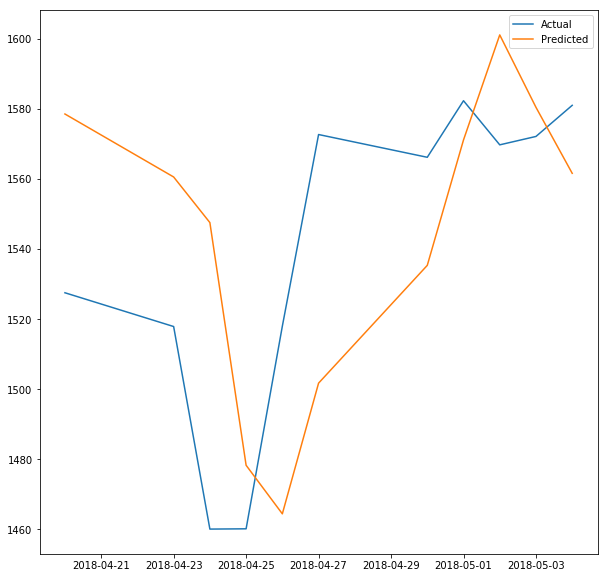

In [8]:
Y_plot = Y_test.copy(deep=True)
Y_plot = Y_plot.to_frame()
Y_plot['Predicted'] = pd.Series(Y_pred, index=Y_plot.index)
Y_plot.columns = ['Actual', 'Predicted']
print(Y_plot.head())

plt.figure(figsize=(10,10))
plt.plot(Y_plot.index, Y_plot['Actual'], label='Actual')
plt.plot(Y_plot.index, Y_plot['Predicted'],label='Predicted')
plt.legend()

plt.show()

## Regression

In [102]:
# Run to get amazon's df
df_current = main()
df_current.head()


30 AMZN success


,X_t,X_t-1,Pos_t-1,Neu_t-1,Neg_t-1
Date,,,,,
2016-05-10,703.07,679.75,NaN,NaN,NaN
2016-05-11,713.23,703.07,NaN,NaN,NaN
2016-05-12,717.93,713.23,NaN,NaN,NaN
2016-05-13,709.92,717.93,NaN,NaN,NaN
2016-05-16,710.66,709.92,NaN,NaN,NaN


In [104]:
# Find index of earlier data
df_current.loc[datetime.datetime(2018,2,7)]
# df_current.loc[df_current['Date'] == datetime.datetime(2018,2,7)]

X_t        1416.78000
X_t-1      1442.84000
Pos_t-1       0.19500
Neu_t-1       0.75050
Neg_t-1       0.05425
Name: 2018-02-07 00:00:00, dtype: float64

In [105]:
# Use this to splice the dataframe to 2018-02-07 and after
df_changed = df_current[456:].fillna(0)
df_changed.head()

,X_t,X_t-1,Pos_t-1,Neu_t-1,Neg_t-1
Date,,,,,
2018-02-07,1416.78,1442.84,0.195000,0.750500,0.054250
2018-02-08,1350.50,1416.78,0.100200,0.856200,0.043400
2018-02-09,1339.60,1350.50,0.163250,0.760250,0.076500
2018-02-12,1386.23,1339.60,0.180000,0.779500,0.040375
2018-02-13,1414.51,1386.23,0.126667,0.755667,0.117667


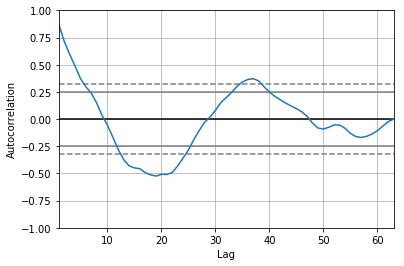

In [110]:
# Plot autocorrelation values
plt.figure()
autocorrelation_plot(df_changed['X_t'])
plt.show()

In [306]:
# Split into train and test
X = df_changed['X_t']
train, test = X[:int(len(X)*(0.8))], X[int(len(X)*(0.8)):]
# Fit the model
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

Lag: 10
Coefficients: const      312.890808
L1.X_t       0.657682
L2.X_t       0.044595
L3.X_t       0.447120
L4.X_t       0.087561
L5.X_t      -0.299498
L6.X_t      -0.056794
L7.X_t      -0.055210
L8.X_t       0.208179
L9.X_t      -0.237377
L10.X_t     -0.004924
dtype: float64


In [307]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
R2 = r2_score(test, predictions)
print('Test R^2 Score: %.3f ' % R2)

predicted=1487.170320, expected=1527.840000
predicted=1485.680652, expected=1556.910000
predicted=1523.658735, expected=1527.490000
predicted=1534.124799, expected=1517.860000
predicted=1528.772591, expected=1460.090000
predicted=1534.694456, expected=1460.170000
predicted=1550.634488, expected=1517.960000
predicted=1560.056127, expected=1572.620000
predicted=1545.616663, expected=1566.130000
predicted=1546.435300, expected=1582.260000
predicted=1558.232553, expected=1569.680000
predicted=1548.752875, expected=1572.075000
predicted=1534.306438, expected=1580.950000
Test MSE: 1773.717
Test R^2 Score: -0.076 


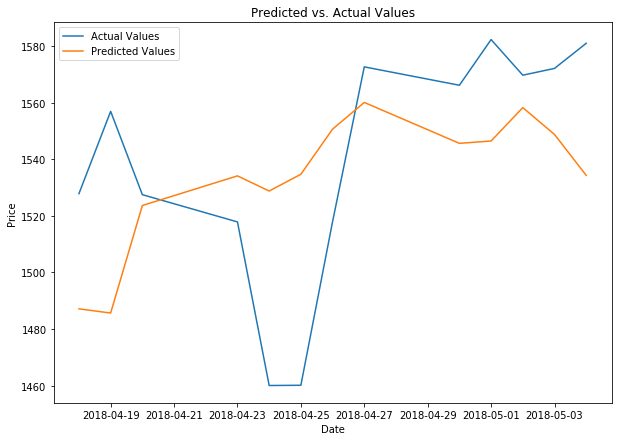

In [308]:
# Plot the preditions
plt.figure(figsize=(10,7))
plt.plot(test, label='Actual Values')
plt.title('Predicted vs. Actual Values')
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(predictions, label='Predicted Values')
plt.legend()
plt.show()